<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a hacer un estudio de simulación probando todas las parejas posibles de métodos de fairness que afecten a distintas partes del proceso de la construcción del algoritmo de machine learning con un dataset simulado en el que hay un solo atributo sensible.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

#Simulacion
from aif360.datasets import BinaryLabelDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook
np.random.seed(seed)

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Simulación de dataset.

El siguiente bloque permite generar el conjunto de datos sobre el que vamos a trabajar.


In [3]:
def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

def simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma):
    
    p = n_var + n_sens
    coef = np.concatenate((gamma, beta))
        
    X = np.random.multivariate_normal(mean_vec, cov, size = n_obs)
    probs_var = inv_logit(X)
    bin = np.random.binomial(1, probs_var)
    
    probs_Y = inv_logit(coef.dot(X.T))
    Y = np.random.binomial(1, probs_Y)
    
    names = ['0' for i in range(p+1)]
    sens = ['0' for i in range(n_sens)]
    var = 1
    
    names[0] = 'response'
    
    for i in range(1,p+1):
        if i-1 < n_sens:
            sens[i-1] = 'sens ' + str(i)
            names[i] = 'sens ' + str(i)
        if i-1 >= n_sens:
            names[i] = 'var ' + str(var)
            var += 1
    
    names = np.array(names)
    sens = np.array(sens)
    response = np.array(['response'])
    
    Y = Y.reshape((n_obs,1))
    
    bin = np.concatenate((Y, bin), axis = 1)
    
    data_pd = pd.DataFrame(bin, columns = names)
    data = BinaryLabelDataset(df = data_pd, favorable_label = 1, unfavorable_label = 0, label_names = response, protected_attribute_names = sens)
    return data

In [4]:
n_obs = 1000
n_var = 30
n_sens = 1
mean_vec = np.zeros(n_var+n_sens)
cov = np.identity(n_var+n_sens)
beta = np.zeros(n_var)
gamma = np.ones(n_sens)

dataset = simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma)

#dataset.favorable_label = 1
#dataset.unfavorable_label = 0

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset.protected_attribute_names[0]
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset)
    
print(f'Dimensiones del conjunto de datos: {dataset.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset.favorable_label)
print("Label del grupo desfavorable:", dataset.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 31)
Grupos privilegiados: [{'sens 1': 1.0}]
Grupos no privilegiados: [{'sens 1': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 8.07 ms, sys: 0 ns, total: 8.07 ms
Wall time: 44.1 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5710
Balanced accuracy: 0.5800
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.5839
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0076
Sufficiency ( |ΔPPV| ) : 0.2458
CPU times: user 173 ms, sys: 26.7 ms, total: 199 ms
Wall time: 1.08 s


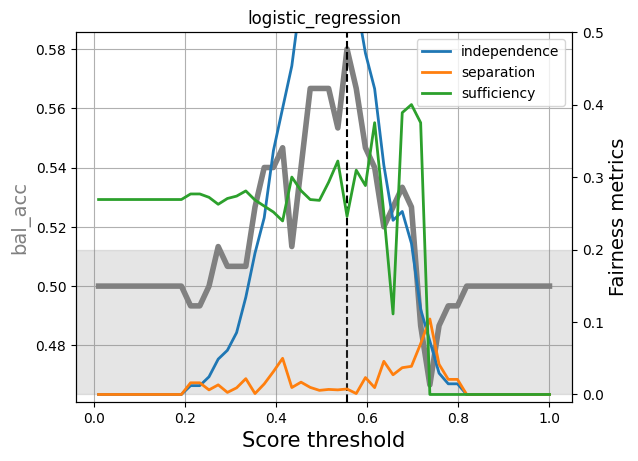

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5641
Balanced accuracy: 0.5481
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.6115
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0623
Sufficiency ( |ΔPPV| ) : 0.4304


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 1h 5min 9s, sys: 3.71 s, total: 1h 5min 13s
Wall time: 5min 32s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282
CPU times: user 3.01 s, sys: 19.8 ms, total: 3.03 s
Wall time: 619 ms


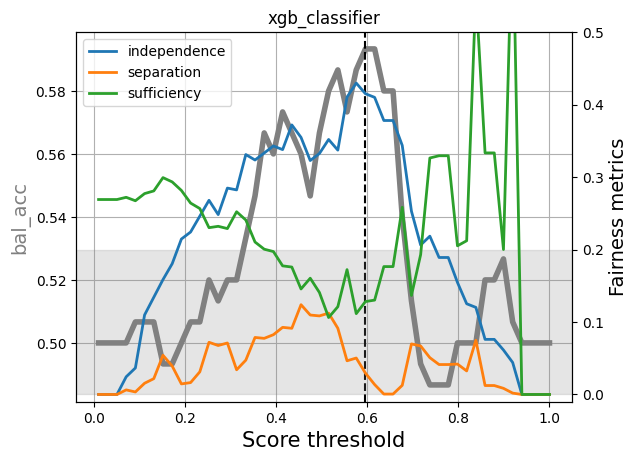

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5484
Balanced accuracy: 0.5263
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.4275
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0316
Sufficiency ( |ΔPPV| ) : 0.3333


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_REW = PreProcessor.transform(data_train_copy)
data_val_REW = PreProcessor.transform(data_val_copy)
data_test_REW = PreProcessor.transform(data_test_copy)

CPU times: user 8.35 ms, sys: 7 µs, total: 8.36 ms
Wall time: 15.4 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

### Eliminador de impacto dispar

In [13]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_DIR = PreProcessor.fit_transform(data_train_copy)
data_val_DIR = PreProcessor.fit_transform(data_val_copy)
data_test_DIR = PreProcessor.fit_transform(data_test_copy)



CPU times: user 204 ms, sys: 11.9 ms, total: 216 ms
Wall time: 763 ms


## Entrenamiento de técnicas de inprocesado

Entrenamos ahora los algoritmos de inprocesado para aplicarlos posteriormente cuando hagan falta.

### Eliminador de prejuicios por regularización

In [14]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [15]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [16]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )
    models[model_name_quality].scores_train = models[model_name_quality].predict(data_train_copy).scores
    models[model_name_quality].scores_val = models[model_name_quality].predict(data_val_copy).scores
    models[model_name_quality].scores_test = models[model_name_quality].predict(data_test_copy).scores

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [17]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Eliminación de prejuicios adversarios

In [18]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

2024-06-14 08:20:01.441303: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-14 08:20:02.424320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.703649; batch adversarial loss: 0.710674
epoch 1; iter: 0; batch classifier loss: 0.689500; batch adversarial loss: 0.714655
epoch 2; iter: 0; batch classifier loss: 0.690497; batch adversarial loss: 0.784963
epoch 3; iter: 0; batch classifier loss: 0.688625; batch adversarial loss: 0.766435
epoch 4; iter: 0; batch classifier loss: 0.741153; batch adversarial loss: 0.753215
epoch 5; iter: 0; batch classifier loss: 0.728264; batch adversarial loss: 0.724927
epoch 6; iter: 0; batch classifier loss: 0.713773; batch adversarial loss: 0.793428
epoch 7; iter: 0; batch classifier loss: 0.696423; batch adversarial loss: 0.772995
epoch 8; iter: 0; batch classifier loss: 0.673310; batch adversarial loss: 0.754911
epoch 9; iter: 0; batch classifier loss: 0.709447; batch adversarial loss: 0.780838
epoch 10; iter: 0; batch classifier loss: 0.671877; batch adversarial loss: 0.752902
epoch 11; iter: 0; batch classifier loss: 0.706745; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.3634
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.2690
CPU times: user 259 ms, sys: 504 ms, total: 763 ms
Wall time: 857 ms


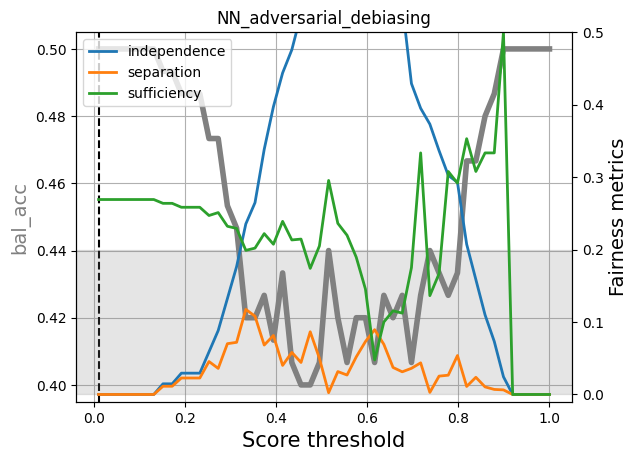

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [20]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

epoch 0; iter: 0; batch classifier loss: 0.698921
epoch 1; iter: 0; batch classifier loss: 0.671260
epoch 2; iter: 0; batch classifier loss: 0.669756
epoch 3; iter: 0; batch classifier loss: 0.691953
epoch 4; iter: 0; batch classifier loss: 0.672357
epoch 5; iter: 0; batch classifier loss: 0.643134
epoch 6; iter: 0; batch classifier loss: 0.649075
epoch 7; iter: 0; batch classifier loss: 0.668087
epoch 8; iter: 0; batch classifier loss: 0.686881
epoch 9; iter: 0; batch classifier loss: 0.650931
epoch 10; iter: 0; batch classifier loss: 0.633014
epoch 11; iter: 0; batch classifier loss: 0.672741
epoch 12; iter: 0; batch classifier loss: 0.677825
epoch 13; iter: 0; batch classifier loss: 0.663317
epoch 14; iter: 0; batch classifier loss: 0.635115
epoch 15; iter: 0; batch classifier loss: 0.633054
epoch 16; iter: 0; batch classifier loss: 0.658485
epoch 17; iter: 0; batch classifier loss: 0.627979
epoch 18; iter: 0; batch classifier loss: 0.643016
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1716
AUC: 0.5061
Balanced accuracy: 0.5533
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2414
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0616
Sufficiency ( |ΔPPV| ) : 0.2320
CPU times: user 182 ms, sys: 27.8 ms, total: 210 ms
Wall time: 599 ms


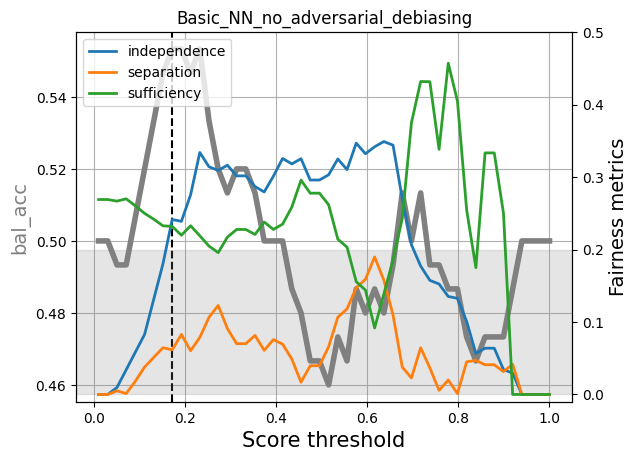

In [21]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Inprocesado

### Reponderación + Eliminador de prejuicios

In [22]:
# Nombre del modelo
model_name = 'reweighting_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + Eliminador de prejuicios

In [ ]:
# Nombre del modelo
model_name = 'disparate_impact_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + metafairness

In [23]:
%%time 
# Nombramos al modelo
model_name = 'reweighing_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [24]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for reweighing_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Impacto dispar + metafairness

In [25]:
%%time 
# Nombramos al modelo
model_name = 'disparate_impact_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

TypeError: cannot unpack non-iterable NoneType object

In [26]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for disparate_impact_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Reponderación + prejuicios adversarios

In [27]:
%%time

# Nombramos al modelo
model_name = 'reweighing_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.696841; batch adversarial loss: 0.734107
epoch 1; iter: 0; batch classifier loss: 0.694413; batch adversarial loss: 0.692409
epoch 2; iter: 0; batch classifier loss: 0.678115; batch adversarial loss: 0.698067
epoch 3; iter: 0; batch classifier loss: 0.683270; batch adversarial loss: 0.733517
epoch 4; iter: 0; batch classifier loss: 0.671957; batch adversarial loss: 0.666289
epoch 5; iter: 0; batch classifier loss: 0.654451; batch adversarial loss: 0.687599
epoch 6; iter: 0; batch classifier loss: 0.665723; batch adversarial loss: 0.683503
epoch 7; iter: 0; batch classifier loss: 0.662329; batch adversarial loss: 0.694871
epoch 8; iter: 0; batch classifier loss: 0.642480; batch adversarial loss: 0.726662
epoch 9; iter: 0; batch classifier loss: 0.640095; batch adversarial loss: 0.692873
epoch 10; iter: 0; batch classifier loss: 0.659419; batch adversarial loss: 0.720539
epoch 11; iter: 0; batch classifier loss: 0.621251; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.4994
Balanced accuracy: 0.5232
Accuracy: 0.5287
Independence ( |ΔP(Y_pred = 1)| ): 0.2162
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0209
Sufficiency ( |ΔPPV| ) : 0.0976
CPU times: user 198 ms, sys: 35.7 ms, total: 234 ms
Wall time: 210 ms


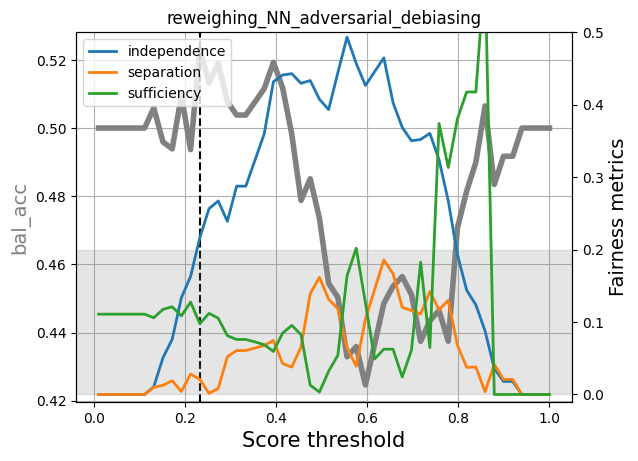

In [28]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + red neuronal normal

In [29]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'reweighin_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.732015
epoch 1; iter: 0; batch classifier loss: 0.692871
epoch 2; iter: 0; batch classifier loss: 0.708210
epoch 3; iter: 0; batch classifier loss: 0.695974
epoch 4; iter: 0; batch classifier loss: 0.698015
epoch 5; iter: 0; batch classifier loss: 0.697163
epoch 6; iter: 0; batch classifier loss: 0.686107
epoch 7; iter: 0; batch classifier loss: 0.664174
epoch 8; iter: 0; batch classifier loss: 0.649932
epoch 9; iter: 0; batch classifier loss: 0.680953
epoch 10; iter: 0; batch classifier loss: 0.654927
epoch 11; iter: 0; batch classifier loss: 0.652812
epoch 12; iter: 0; batch classifier loss: 0.662458
epoch 13; iter: 0; batch classifier loss: 0.640272
epoch 14; iter: 0; batch classifier loss: 0.660811
epoch 15; iter: 0; batch classifier loss: 0.667908
epoch 16; iter: 0; batch classifier loss: 0.659604
epoch 17; iter: 0; batch classifier loss: 0.613400
epoch 18; iter: 0; batch classifier loss: 0.634037
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.2120
AUC: 0.5040
Balanced accuracy: 0.5512
Accuracy: 0.5564
Independence ( |ΔP(Y_pred = 1)| ): 0.2035
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1151
Sufficiency ( |ΔPPV| ) : 0.0399
CPU times: user 204 ms, sys: 3.99 ms, total: 208 ms
Wall time: 197 ms


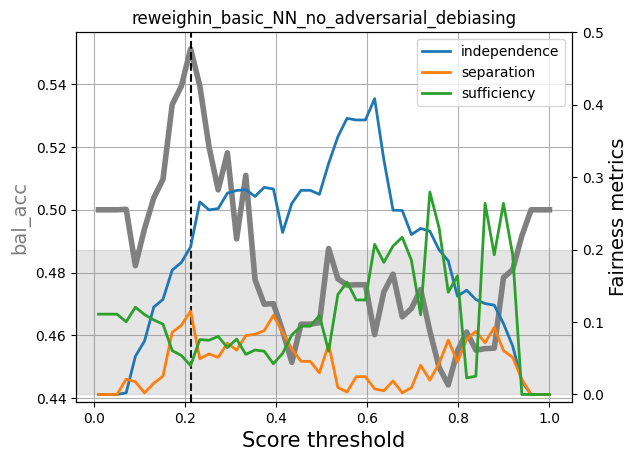

In [30]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + eliminación de prejuicios adversarios

In [31]:
%%time

# Nombramos al modelo
model_name = 'disparate_impact_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.691709; batch adversarial loss: 0.722597
epoch 1; iter: 0; batch classifier loss: 0.710215; batch adversarial loss: 0.712412
epoch 2; iter: 0; batch classifier loss: 0.701269; batch adversarial loss: 0.680852
epoch 3; iter: 0; batch classifier loss: 0.712248; batch adversarial loss: 0.674949
epoch 4; iter: 0; batch classifier loss: 0.675472; batch adversarial loss: 0.653047
epoch 5; iter: 0; batch classifier loss: 0.678720; batch adversarial loss: 0.662178
epoch 6; iter: 0; batch classifier loss: 0.653555; batch adversarial loss: 0.706850
epoch 7; iter: 0; batch classifier loss: 0.665593; batch adversarial loss: 0.695552
epoch 8; iter: 0; batch classifier loss: 0.655730; batch adversarial loss: 0.740561
epoch 9; iter: 0; batch classifier loss: 0.676637; batch adversarial loss: 0.673830
epoch 10; iter: 0; batch classifier loss: 0.642124; batch adversarial loss: 0.699297
epoch 11; iter: 0; batch classifier loss: 0.680450; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4343
AUC: 0.5648
Balanced accuracy: 0.6000
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.4505
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0503
Sufficiency ( |ΔPPV| ) : 0.2006
CPU times: user 357 ms, sys: 75.4 ms, total: 433 ms
Wall time: 526 ms


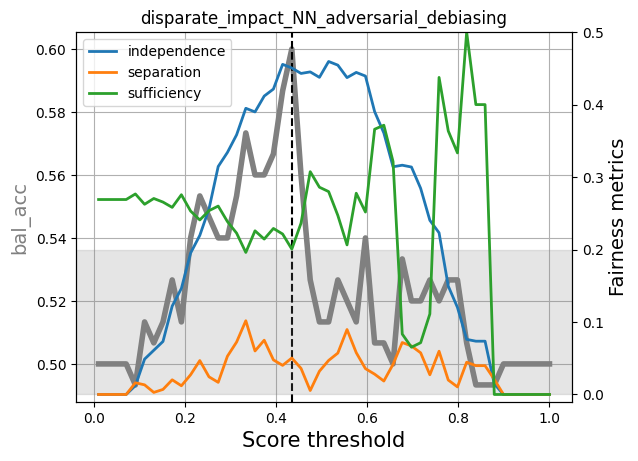

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + red neuronal normal

In [33]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'disparate_impact_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.678828
epoch 1; iter: 0; batch classifier loss: 0.695452
epoch 2; iter: 0; batch classifier loss: 0.740808
epoch 3; iter: 0; batch classifier loss: 0.691158
epoch 4; iter: 0; batch classifier loss: 0.691549
epoch 5; iter: 0; batch classifier loss: 0.681561
epoch 6; iter: 0; batch classifier loss: 0.660986
epoch 7; iter: 0; batch classifier loss: 0.671786
epoch 8; iter: 0; batch classifier loss: 0.641778
epoch 9; iter: 0; batch classifier loss: 0.665101
epoch 10; iter: 0; batch classifier loss: 0.633116
epoch 11; iter: 0; batch classifier loss: 0.641094
epoch 12; iter: 0; batch classifier loss: 0.616340
epoch 13; iter: 0; batch classifier loss: 0.641355
epoch 14; iter: 0; batch classifier loss: 0.639130
epoch 15; iter: 0; batch classifier loss: 0.640062
epoch 16; iter: 0; batch classifier loss: 0.627953
epoch 17; iter: 0; batch classifier loss: 0.626779
epoch 18; iter: 0; batch classifier loss: 0.637958
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5068
Balanced accuracy: 0.5667
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.1926
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1002
Sufficiency ( |ΔPPV| ) : 0.2110
CPU times: user 198 ms, sys: 7.97 ms, total: 206 ms
Wall time: 241 ms


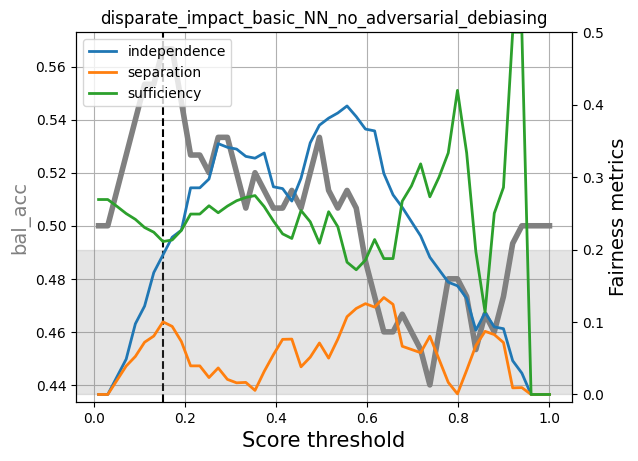

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Postprocesado

### Entrenamiento de modelos con técnicas de preprocesado

#### Reponderación

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.4768
Balanced accuracy: 0.5079
Accuracy: 0.5009
Independence ( |ΔP(Y_pred = 1)| ): 0.0147
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 1.0000


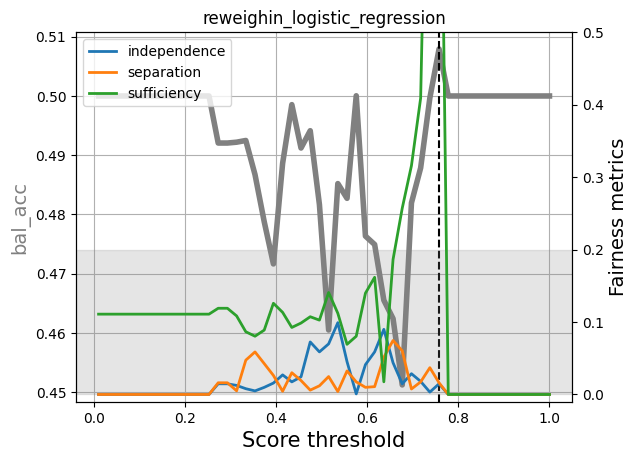

In [35]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Regresión logística
model_name = 'reweighin_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5664
Balanced accuracy: 0.5629
Accuracy: 0.5603
Independence ( |ΔP(Y_pred = 1)| ): 0.3970
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0137
Sufficiency ( |ΔPPV| ) : 0.0254
CPU times: user 1h 3min 35s, sys: 3.07 s, total: 1h 3min 38s
Wall time: 3min 5s


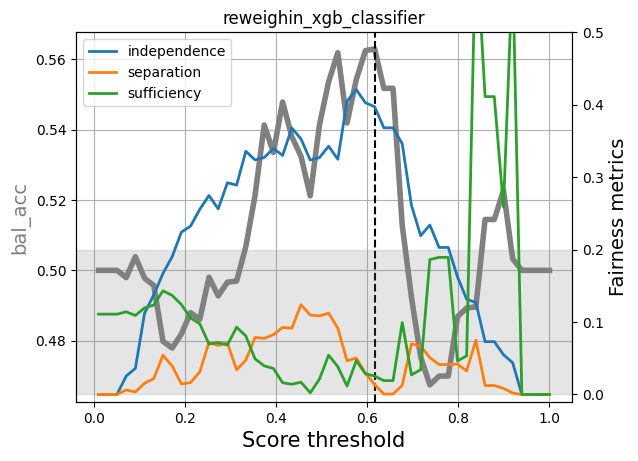

In [36]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'reweighin_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Disparate impact

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5710
Balanced accuracy: 0.5800
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.5839
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0076
Sufficiency ( |ΔPPV| ) : 0.2458


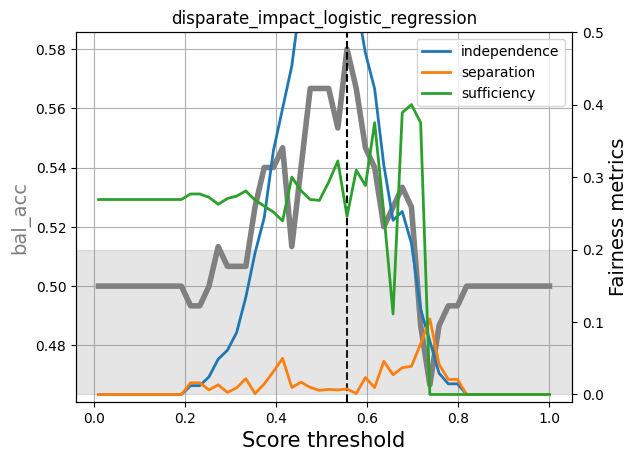

In [37]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Regresión logística
model_name = 'disparate_impact_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282
CPU times: user 1h 2min 20s, sys: 2.56 s, total: 1h 2min 23s
Wall time: 2min


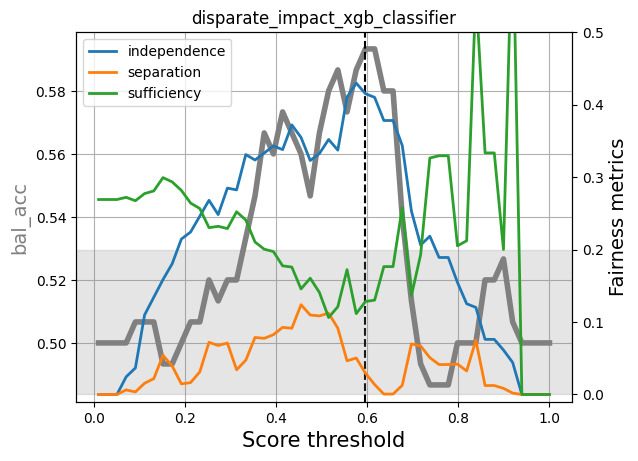

In [38]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'disparate_impact_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [39]:
#Anotamos los nombres de los modelos
model_names = ['reweighin_logistic_regression', 'reweighin_xgb_classifier', 'disparate_impact_logistic_regression', 'disparate_impact_xgb_classifier']

### Aplicación de técnicas de postprocesado 

#### Reponderación + Clasificación de rechazo de opción

In [40]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.7 s, sys: 4.02 s, total: 14.7 s
Wall time: 9.75 s


In [41]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

reweighin_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4060
AUC: 0.4768
Balanced accuracy: 0.4867
Accuracy: 0.4867
Independence ( |ΔP(Y_pred = 1)| ): 0.0018
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 0.2779


reweighin_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4852
AUC: 0.4768
Balanced accuracy: 0.5200
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.0495
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0047
Sufficiency ( |ΔPPV| ) : 0.2713


reweighin_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5247
AUC: 0.4768
Balanced accuracy: 0.4733
Accuracy: 0.4733
Independence ( |ΔP(Y_pred = 1)| ): 0.0854
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0159
Sufficiency ( |ΔPPV| ) : 0.2941




In [42]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.5 s, sys: 164 ms, total: 14.7 s
Wall time: 10.2 s


In [43]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

reweighin_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.5664
Balanced accuracy: 0.3867
Accuracy: 0.3867
Independence ( |ΔP(Y_pred = 1)| ): 0.7313
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0752
Sufficiency ( |ΔPPV| ) : 0.4515


reweighin_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583


reweighin_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583




#### Impacto dispar + Rechazo de opción

In [44]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.9 s, sys: 3.97 s, total: 14.8 s
Wall time: 9.96 s


In [45]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

disparate_impact_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4654
AUC: 0.5710
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.0502
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0164
Sufficiency ( |ΔPPV| ) : 0.2587


disparate_impact_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4951
AUC: 0.5710
Balanced accuracy: 0.5133
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0567
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0215
Sufficiency ( |ΔPPV| ) : 0.2516


disparate_impact_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.4555
AUC: 0.5710
Balanced accuracy: 0.5067
Accuracy: 0.5067
Independence ( |ΔP(Y_pred = 1)| ): 0.0477
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0177
Sufficiency ( |ΔPPV| ) : 0.2582




In [46]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.4 s, sys: 124 ms, total: 14.5 s
Wall time: 9.92 s


In [47]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

disparate_impact_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.5664
Balanced accuracy: 0.3867
Accuracy: 0.3867
Independence ( |ΔP(Y_pred = 1)| ): 0.7313
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0752
Sufficiency ( |ΔPPV| ) : 0.4515


disparate_impact_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583


disparate_impact_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583




#### Reponderación y impacto dispar + Escalado de Platt por grupos

In [48]:
%%time
fairness_method = '_platt_scaling'
model_names = model_names
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for reweighin_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.6336
AUC: 0.6519
Balanced accuracy: 0.6533
Accuracy: 0.6533
Independence ( |ΔP(Y_pred = 1)| ): 0.9559
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0625
Sufficiency ( |ΔPPV| ) : 0.6769

Validation set results for reweighin_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.6249
AUC: 0.6542
Balanced accuracy: 0.6400
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.8676
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0587
Sufficiency ( |ΔPPV| ) : 0.6780

Validation set results for disparate_impact_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.6336
AUC: 0.6508
Balanced accuracy: 0.6400
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.9853
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0208
Sufficiency ( |ΔPPV| ) : 0.6567

Validation set results for disparate_impact_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.6249
AUC: 0.6542
Balanced

In [49]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Reponderación + Procesador de probabilidades igualadas

##### Usando labels

In [50]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [51]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [52]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [53]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [54]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 306 ms, sys: 547 ms, total: 854 ms
Wall time: 22.9 ms


In [55]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for reweighin_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.4768
Balanced accuracy: 0.5267
Accuracy: 0.5267
Independence ( |ΔP(Y_pred = 1)| ): 0.1779
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0468
Sufficiency ( |ΔPPV| ) : 0.2083


Results for reweighin_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.4343
AUC: 0.4768
Balanced accuracy: 0.5133
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0405
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0496
Sufficiency ( |ΔPPV| ) : 0.2395


Results for reweighin_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.7576
AUC: 0.4768
Balanced accuracy: 0.5067
Accuracy: 0.5067
Independence ( |ΔP(Y_pred = 1)| ): 0.0122
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0161
Sufficiency ( |ΔPPV| ) : 1.0000




In [56]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.13 s, sys: 156 ms, total: 5.29 s
Wall time: 95.4 ms


In [57]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for reweighin_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282


Results for reweighin_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4107
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0990
Sufficiency ( |ΔPPV| ) : 0.1166


Results for reweighin_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282




#### Impacto dispar + Procesador de probabilidades igualadas

##### Usando labels

In [58]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [59]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [60]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [61]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

##### Usando scores

In [62]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 159 ms, sys: 854 ms, total: 1.01 s
Wall time: 27.7 ms


In [63]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for disparate_impact_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5710
Balanced accuracy: 0.5800
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.5839
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0076
Sufficiency ( |ΔPPV| ) : 0.2458


Results for disparate_impact_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5710
Balanced accuracy: 0.6200
Accuracy: 0.6200
Independence ( |ΔP(Y_pred = 1)| ): 0.8780
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0057
Sufficiency ( |ΔPPV| ) : 0.2471


Results for disparate_impact_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.4747
AUC: 0.5710
Balanced accuracy: 0.6133
Accuracy: 0.6133
Independence ( |ΔP(Y_pred = 1)| ): 0.8971
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0152
Sufficiency ( |ΔPPV| ) : 0.6393




In [64]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.08 s, sys: 131 ms, total: 5.22 s
Wall time: 93.6 ms


In [65]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for disparate_impact_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282


Results for disparate_impact_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4107
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0990
Sufficiency ( |ΔPPV| ) : 0.1166


Results for disparate_impact_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5664
Balanced accuracy: 0.5933
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4150
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0295
Sufficiency ( |ΔPPV| ) : 0.1282




## Inprocesado + Postprocesado

In [66]:
#Anotamos los nombres de los modelos que vamos a usar
model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']

### Eliminador de prejuicios + rechazo de opción

In [67]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

In [68]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

KeyError: 'prejudice_remover_reject_option_spd'

### Metafairness + rechazo de opción

In [69]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 13.4 s, sys: 184 ms, total: 13.6 s
Wall time: 13.6 s


In [70]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_sr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.5664
Balanced accuracy: 0.3867
Accuracy: 0.3867
Independence ( |ΔP(Y_pred = 1)| ): 0.7313
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0752
Sufficiency ( |ΔPPV| ) : 0.4515


meta_fairness_sr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583


meta_fairness_sr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583




### Prejuicios adversarios + rechazo de opción

In [71]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.1 s, sys: 196 ms, total: 14.3 s
Wall time: 14.3 s


In [72]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_fdr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.5664
Balanced accuracy: 0.3867
Accuracy: 0.3867
Independence ( |ΔP(Y_pred = 1)| ): 0.7313
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0752
Sufficiency ( |ΔPPV| ) : 0.4515


meta_fairness_fdr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583


meta_fairness_fdr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583




### Red neuronal normal + rechazo de opción

In [73]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.3 s, sys: 168 ms, total: 14.5 s
Wall time: 14.6 s


In [74]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

NN_adversarial_debiasing_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.5664
Balanced accuracy: 0.3867
Accuracy: 0.3867
Independence ( |ΔP(Y_pred = 1)| ): 0.7313
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0752
Sufficiency ( |ΔPPV| ) : 0.4515


NN_adversarial_debiasing_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583


NN_adversarial_debiasing_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2179
AUC: 0.5664
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.2095
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0277
Sufficiency ( |ΔPPV| ) : 0.2583




### Inprocesado + Escalado Platt por grupos

In [75]:
%%time
fairness_method = '_platt_scaling'

model_names = ['NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['meta_fairness_fdr', 'meta_fairness_sr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
    
for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                            'unpriv': [data_val_preds_unpriv, unpriv_indices]}
    
    for group, data_group_list in sensitive_groups_data.items():
    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)
    
        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()
    
        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                      data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
            
        # Evaluamos a los modelos para el rango de umbrales
        thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                         np.max(data_val_preds2.scores.ravel()),
                                         50)
    
        metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
                dataset_true = data_val_copy,
                dataset_preds = data_val_preds2,
                thresh_arr = thresh_sweep_platt
            )
    
        # Evaluamos las métricas para el mejor umbral y las guardamos
        metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )
    
        # Graficamos el comportamiento del modelo para el rango de umbrales 
        print('\nValidation set results for {}'.format(model_name))
        utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
        # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
        # plt.title( model_name+fairness_method )
        
        f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
        a.set_title(model_name+fairness_method )
        f


Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5955
AUC: 0.4860
Balanced accuracy: 0.5467
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.2073
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0370
Sufficiency ( |ΔPPV| ) : 0.2471

Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.6235
AUC: 0.6562
Balanced accuracy: 0.6400
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.8676
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0587
Sufficiency ( |ΔPPV| ) : 0.6780

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5752
AUC: 0.6037
Balanced accuracy: 0.6067
Accuracy: 0.6067
Independence ( |ΔP(Y_pred = 1)| ): 0.6704
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0382
Sufficiency ( |ΔPPV| ) : 0.2857

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5850
AUC: 0.6548
Balanced accur

In [76]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Eliminador de prejuicios + Procesador de probabilidades igualadas

##### Usando labels

In [77]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

RuntimeError: Attempted to use a closed Session.

In [78]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

KeyError: 'NN_adversarial_debiasing_equal_odds'

#### Usando scores

In [79]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

RuntimeError: Attempted to use a closed Session.

In [80]:
display(Markdown("**Validation set results for prejudice remover**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for prejudice remover**

Results for NN_adversarial_debiasing_equal_odds_weighted


KeyError: 'NN_adversarial_debiasing_equal_odds_weighted'

#### Metafairness + Procesador de probabilidades igualadas

##### Usando labels

In [81]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

2024-06-14 09:13:59.290159: W tensorflow/c/c_api.cc:305] Operation '{name:'biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign' id:264 op device:{requested: '', assigned: ''} def:{{{node biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](biased_classifier/biased_classifier/classifier_model/b2/Adam_1, biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [82]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [83]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 32.4 ms, sys: 7.94 ms, total: 40.3 ms
Wall time: 30 ms


In [84]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1716
AUC: 0.5061
Balanced accuracy: 0.5533
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2414
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0616
Sufficiency ( |ΔPPV| ) : 0.2320


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5061
Balanced accuracy: 0.5667
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3633
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0560
Sufficiency ( |ΔPPV| ) : 0.2300


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5061
Balanced accuracy: 0.5467
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1316
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0771
Sufficiency ( |ΔPPV| ) : 0.2275




##### Usando labels

In [85]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [86]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [87]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [88]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1716
AUC: 0.5061
Balanced accuracy: 0.5533
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2414
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0616
Sufficiency ( |ΔPPV| ) : 0.2320


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5061
Balanced accuracy: 0.5667
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3633
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0560
Sufficiency ( |ΔPPV| ) : 0.2300


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5061
Balanced accuracy: 0.5467
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1316
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0771
Sufficiency ( |ΔPPV| ) : 0.2275




#### Prejuicios adversarios + Procesador de probabilidades igualadas

##### Usando labels

In [89]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [90]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [91]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [92]:
display(Markdown("**Validation set results for adversarial debiasing**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for adversarial debiasing**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1716
AUC: 0.5061
Balanced accuracy: 0.5533
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2414
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0616
Sufficiency ( |ΔPPV| ) : 0.2320


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5061
Balanced accuracy: 0.5667
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3633
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0560
Sufficiency ( |ΔPPV| ) : 0.2300


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5061
Balanced accuracy: 0.5467
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1316
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0771
Sufficiency ( |ΔPPV| ) : 0.2275




#### Red neuronal normal + Procesador de probabilidades igualadas

##### Usando labels

In [93]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [94]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [95]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [96]:
display(Markdown("**Validation set results for basic NN**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for basic NN**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.1716
AUC: 0.5061
Balanced accuracy: 0.5533
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2414
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0616
Sufficiency ( |ΔPPV| ) : 0.2320


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5061
Balanced accuracy: 0.5667
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3633
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0560
Sufficiency ( |ΔPPV| ) : 0.2300


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.1514
AUC: 0.5061
Balanced accuracy: 0.5467
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1316
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0771
Sufficiency ( |ΔPPV| ) : 0.2275




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [97]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.555510,0.580000,0.580000,0.583931,0.007587,0.245833,0.571022
xgb_classifier,0.595918,0.593333,0.593333,0.414993,0.029458,0.128205,0.566400
NN_adversarial_debiasing,0.010000,0.500000,0.500000,0.000000,0.000000,0.269010,0.363378
Basic_NN_no_adversarial_debiasing,0.171633,0.553333,0.553333,0.241392,0.061648,0.231955,0.506133
reweighing_NN_adversarial_debiasing,0.232245,0.523212,0.528669,0.216219,0.020873,0.097615,0.499378
reweighin_basic_NN_no_adversarial_debiasing,0.212041,0.551210,0.556391,0.203525,0.115074,0.039913,0.504000
disparate_impact_NN_adversarial_debiasing,0.434286,0.600000,0.600000,0.450502,0.050313,0.200627,0.564800
disparate_impact_basic_NN_no_adversarial_debiasing,0.151429,0.566667,0.566667,0.192611,0.100231,0.211022,0.506844
reweighin_logistic_regression,0.757551,0.507947,0.500908,0.014740,0.016129,1.000000,0.476800
reweighin_xgb_classifier,0.616122,0.562907,0.560342,0.397031,0.013664,0.025387,0.566400


### Resultados en test

In [98]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.555510,0.548137,0.553333,0.611472,0.062263,0.430427,0.564093
xgb_classifier,0.595918,0.526297,0.533333,0.427489,0.031565,0.333333,0.548404
NN_adversarial_debiasing,0.010000,0.500000,0.473333,0.000000,0.000000,0.237013,0.346764
Basic_NN_no_adversarial_debiasing,0.171633,0.528080,0.506667,0.178571,0.013694,0.229249,0.481369
reweighing_NN_adversarial_debiasing,0.232245,0.511400,0.495838,0.141140,0.010956,0.070615,0.534855
reweighin_basic_NN_no_adversarial_debiasing,0.212041,0.496573,0.481971,0.139783,0.029260,0.061590,0.485113
disparate_impact_NN_adversarial_debiasing,0.434286,0.486361,0.480000,0.435065,0.092248,0.346491,0.523801
disparate_impact_basic_NN_no_adversarial_debiasing,0.151429,0.502763,0.480000,0.049784,0.004552,0.234754,0.495275
reweighin_logistic_regression,0.757551,0.494409,0.512643,0.010426,0.009434,0.000000,0.496167
reweighin_xgb_classifier,0.616122,0.461298,0.467383,0.369358,0.030935,0.124879,0.548404


In [99]:
algorithm_performance_summary.to_csv('SIMULATION_MULTALG_high', index = True, sep=',', encoding='utf-8')